In [5]:
import os
import string
import sys
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from xgboost import XGBRegressor
sys.path.append("../code/.")
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from catboost import CatBoostRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import LeaveOneOut
import seaborn as sns
df_ml = pd.read_csv("./df_interp_ml.csv", low_memory=False)
df_ml.describe(include='all')

raw_data_num = df_ml.shape[0]
mean = df_ml['residual'].mean()
df_ml['residual'].mean()
std = df_ml['residual'].std()
outlier_condition = (df_ml['residual'] > mean + 3 * std) | (df_ml['residual'] < mean - 3 * std)
df_ml = df_ml[~outlier_condition]
print("cleaned %d samples, remain %d samples" % (df_ml.shape[0] - raw_data_num, df_ml.shape[0]))

cleaned -10 samples, remain 1285 samples


In [7]:
ordinal_cols = ['Size.Category']
features = ['Draught..m.', 'HP.Total.Propulsion', 'Service.Speed..knots.', 'LOA..m.',
                        'Operational.Speed..knots.', 'NT', 'Ballast.Cap..cu.m.',
                        'Bale.Capacity..cu.m.', 'LBP..m.', 'Speed..knots.',
                        'West.Coast.Africa.Deployment..Time.in.Last.12.Months....', 'EU.distance',
                        'distance_sum', 'work_sum', 'trip_nunique',
                        'W_component_first', 'ME_W_ref_first', 't_m_times_v_n_sum',
                        't_over_t_ref_with_m_sum', 't_over_t_ref_without_m_sum',
                        'v_over_v_ref_with_n_sum', 'v_over_v_ref_without_n_sum', 'age', "miss_pct_sea_",'Size.Category']

log_transform_cols = ['Draught..m.', 'HP.Total.Propulsion', 'Service.Speed..knots.', 'LOA..m.',
                        'Operational.Speed..knots.', 'NT', 'Ballast.Cap..cu.m.',
                        'Bale.Capacity..cu.m.', 'LBP..m.', 'Speed..knots.',
                        'West.Coast.Africa.Deployment..Time.in.Last.12.Months....', 'EU.distance',
                        'distance_sum', 'work_sum', 'trip_nunique',
                        'W_component_first', 'ME_W_ref_first', 't_m_times_v_n_sum',
                        't_over_t_ref_with_m_sum', 't_over_t_ref_without_m_sum',
                        'v_over_v_ref_with_n_sum', 'v_over_v_ref_without_n_sum', 'age', "miss_pct_sea_"]


median_imputer = SimpleImputer(strategy='median')

standard_scaler = StandardScaler()

log_transformer = FunctionTransformer(np.log1p, validate=True)
ordinal_transformer = make_pipeline(OrdinalEncoder(categories=[['Capesize', 'Panamax', 'Handymax', 'Handysize']]))


impute_and_transform = Pipeline(steps=[('imputer', median_imputer),
                                       ('log_transform', log_transformer)])

preprocessor_linear = ColumnTransformer(
    transformers=[
        ('impute_scale_transform', impute_and_transform, log_transform_cols),
        ('ordinal', ordinal_transformer, ordinal_cols)])

preprocessor_trees = ColumnTransformer(
    transformers=[
        ('impute_and_transform', impute_and_transform, log_transform_cols),
        ('ordinal', ordinal_transformer, ordinal_cols)
        ])



def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

Model: gbdt, Mean for r2: 0.97914, Standard Deviation for r2: 0.00397, Mean for MSE:0.01025, Standard Deviation for MSE: 0.00182
Model: gbdt (onehot), Mean for r2: 0.97914, Standard Deviation for r2: 0.00397, Mean for MSE:0.01025, Standard Deviation for MSE: 0.00182
Model: linear regression, Mean for r2: 0.96339, Standard Deviation for r2: 0.00554, Mean for MSE:0.01798, Standard Deviation for MSE: 0.00237
Model: linear regression (onehot), Mean for r2: 0.96339, Standard Deviation for r2: 0.00554, Mean for MSE:0.01798, Standard Deviation for MSE: 0.00237
Model: ridge, Mean for r2: 0.96307, Standard Deviation for r2: 0.00541, Mean for MSE:0.01809, Standard Deviation for MSE: 0.00233
Model: ridge (onehot), Mean for r2: 0.96307, Standard Deviation for r2: 0.00541, Mean for MSE:0.01809, Standard Deviation for MSE: 0.00233

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


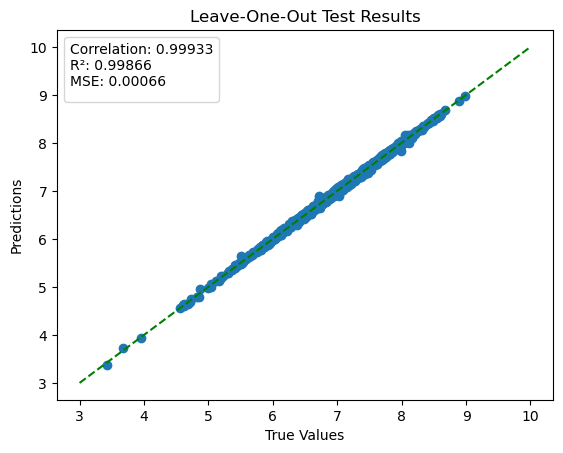

In [30]:
pipe = make_pipeline(preprocessor_trees, GradientBoostingRegressor(n_estimators=2000, learning_rate=0.1, max_depth=3,
                                max_features='sqrt', min_samples_leaf=20, loss='squared_error',
                                min_samples_split=20, warm_start=True))
results_var = ['total.fc', 'FC_sum']
FC_sum = df_ml['FC_sum'].values / 1000000
total_fc = df_ml['total.fc'] 
y = df_ml['residual']
X = df_ml

# Leave-One-Out Cross-Validation
loo = LeaveOneOut()
res_predictions = np.zeros(len(y))

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    pipe.fit(X_train, y_train)

    # Predict on the test set
    y_pred = pipe.predict(X_test)

    res_predictions[test_index] = y_pred
y_prediction = np.log(FC_sum) + res_predictions
# Plotting the results
# Calculate R-squared
r_squared_mod = r2_score(np.log(total_fc), y_prediction)

# Calculate correlation
correlation_mod = np.corrcoef(np.log(total_fc), y_prediction)[0, 1]

# Calculate mean squared error
mse_mod = mean_squared_error(np.log(total_fc), y_prediction)
legend_title = 'Correlation: {:.5f}\nR²: {:.5f}\nMSE: {:.5f}'.format(correlation_mod, r_squared_mod, mse_mod)
plt.legend(title=legend_title)
plt.scatter(np.log(total_fc), y_prediction, label='data')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Leave-One-Out Test Results')
plt.plot([3, 10], [3, 10], 'g--', label='x=y line')
plt.show()

In [24]:
print(r2_score(np.log(total_fc), y_prediction))
print(mean_squared_error(np.log(total_fc), y_prediction))

0.9985912011163002
0.000698617521474007


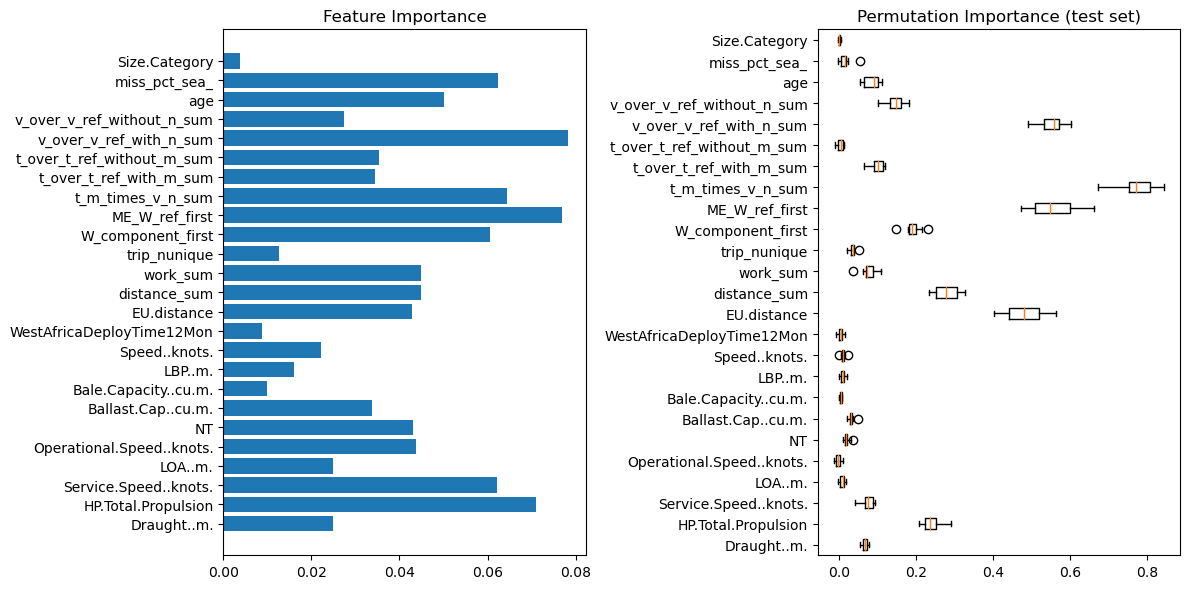

In [10]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingRegressor
results_var = ['total.fc', 'FC_sum']
X_train, X_test, y_train, y_test = train_test_split(df_ml[features + results_var], df_ml['residual'], test_size=0.2)
pipe = make_pipeline(preprocessor_trees, GradientBoostingRegressor(n_estimators=2000, learning_rate=0.1, max_depth=3,
                                max_features='sqrt', min_samples_leaf=20, loss='squared_error',
                                min_samples_split=20, warm_start=True))
features_name = ['Draught..m.', 'HP.Total.Propulsion', 'Service.Speed..knots.', 'LOA..m.',
                        'Operational.Speed..knots.', 'NT', 'Ballast.Cap..cu.m.',
                        'Bale.Capacity..cu.m.', 'LBP..m.', 'Speed..knots.',
                        'WestAfricaDeployTime12Mon', 'EU.distance',
                        'distance_sum', 'work_sum', 'trip_nunique',
                        'W_component_first', 'ME_W_ref_first', 't_m_times_v_n_sum',
                        't_over_t_ref_with_m_sum', 't_over_t_ref_without_m_sum',
                        'v_over_v_ref_with_n_sum', 'v_over_v_ref_without_n_sum', 'age', "miss_pct_sea_",'Size.Category']

total_fc = X_test['total.fc'].values
FC_sum = X_test['FC_sum'].values / 1000000
X_train.drop(columns=results_var, inplace=True)
X_test.drop(columns=results_var, inplace=True)
pipe.fit(X_train, y_train)
feature_importance = pipe[1].feature_importances_


fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
pos = np.arange(feature_importance.shape[0]) + 0.5
plt.barh(pos, feature_importance, align="center")
plt.yticks(pos, features_name)
plt.title("Feature Importance")

result = permutation_importance(
    pipe, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances.T,
    vert=False,
    labels=np.array(features_name),
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [60]:
feature_importance

array([0.02613514, 0.06828854, 0.06249712, 0.01711646, 0.04450848,
       0.02410524, 0.02729332, 0.0115148 , 0.02516619, 0.02517246,
       0.01284912, 0.03914151, 0.02996715, 0.05528603, 0.01747142,
       0.07492257, 0.09080105, 0.05585457, 0.03600941, 0.03132245,
       0.07489057, 0.03917023, 0.04651197, 0.06053712, 0.00346709])

In [69]:
from sklearn.feature_selection import SelectFromModel


select_rf = SelectFromModel(LinearRegression(), threshold="mean")
pipe_gbt_model_based = make_pipeline(
    preprocessor_trees,select_rf, 
    GradientBoostingRegressor(n_estimators=2000, learning_rate=0.1, max_depth=3,
                                max_features='sqrt', min_samples_leaf=20, loss='squared_error',
                                min_samples_split=20, warm_start=True)
)

param_grid_selector = {
        'selectfrommodel__estimator':[Ridge(alpha=0.01), Ridge(alpha=0.1), Ridge(alpha=0.5),Ridge(alpha=1), LinearRegression(), RandomForestRegressor(n_estimators=10),RandomForestRegressor(n_estimators=100), RandomForestRegressor(n_estimators=500),
                                      RandomForestRegressor(n_estimators=1000),RandomForestRegressor(n_estimators=2000),RandomForestRegressor(n_estimators=5000),
                                      RandomForestRegressor(n_estimators=10000)],
        'selectfrommodel__threshold':['mean','median']
}

grid_search_selector = GridSearchCV(pipe_gbt_model_based,param_grid_selector,cv=5,scoring='r2',n_jobs=-1)
grid_search_selector.fit(X_train,y_train)

print(f"Best parameters for the selector is: {grid_search_selector.best_params_}")
print(f"Best score for the selector is: {grid_search_selector.best_score_}")
print(f"Test score for the selector is: {grid_search_selector.score(X_test, y_test)}")

/Users/x.zhao/miniconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for the selector is: {'selectfrommodel__estimator': Ridge(alpha=0.1), 'selectfrommodel__threshold': 'median'}
Best score for the selector is: 0.5023734014210893
Test score for the selector is: 0.48936520785545845


In [70]:
for i in range(0,1000):
        X_train, X_test, y_train, y_test = train_test_split(df_ml[features + results_var], df_ml['residual'], test_size=0.2)
        pipe = grid_search_selector.best_estimator_
        total_fc = X_test['total.fc'].values
        FC_sum = X_test['FC_sum'].values / 1000000

        # Generate x values and fitted y values
        predicted_residual = pipe.predict(X_test)

        y_values = np.log(FC_sum) + predicted_residual
        x_values = np.log(total_fc)
        # Calculate R-squared
        r_squared = r2_score(x_values, y_values)

        # Calculate correlation
        correlation = np.corrcoef(x_values, y_values)[0, 1]

        # Calculate mean squared error
        mse = mean_squared_error(x_values, y_values)
        
         # Calculate R-squared for residual
        # r_squared_r = r2_score(y_test, predicted_residual)

        # # Calculate correlation
        # correlation_r = np.corrcoef(y_test, predicted_residual)[0, 1]

        # # Calculate mean squared error
        # mse_r = mean_squared_error(y_test, predicted_residual)
        new_row = pd.DataFrame({'Model': [model],'r2':[r_squared], 'correlation':[correlation], 'MSE':[mse]})

        # Appending the new row
        test_results = pd.concat([test_results, new_row], ignore_index=True)


mean = test_results['r2'].mean()
std_dev = test_results['r2'].std()
mean_mse = test_results['MSE'].mean()
std_mse = test_results['MSE'].std()

In [71]:
print(f"Model: {model}, Mean for r2: {mean:.5f}, Standard Deviation for r2: {std_dev:.5f}, Mean for MSE:{mean_mse:.5f}, Standard Deviation for MSE: {std_mse:.5f}")

Model: lasso, Mean for r2: 0.98651, Standard Deviation for r2: 0.00633, Mean for MSE:0.00662, Standard Deviation for MSE: 0.00301


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


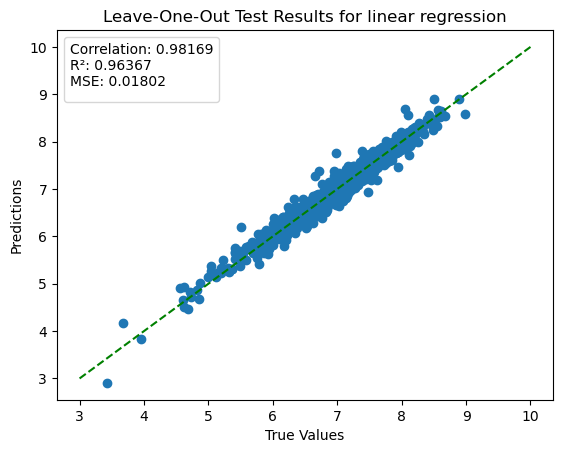

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


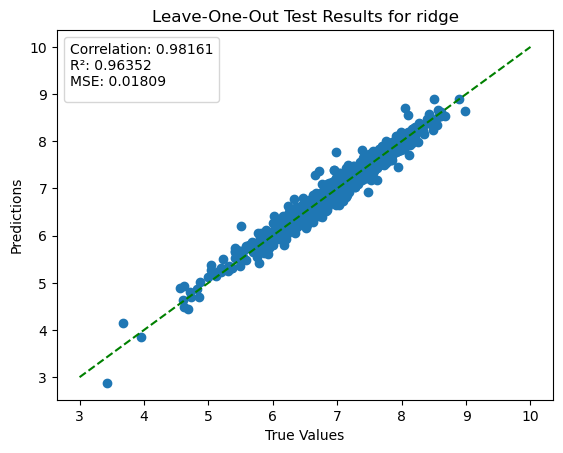

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


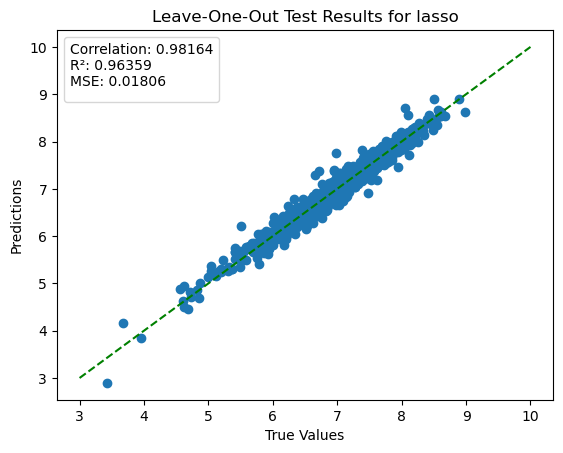

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


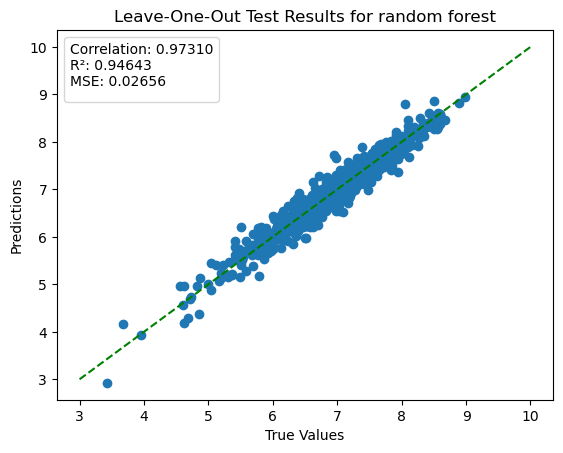

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


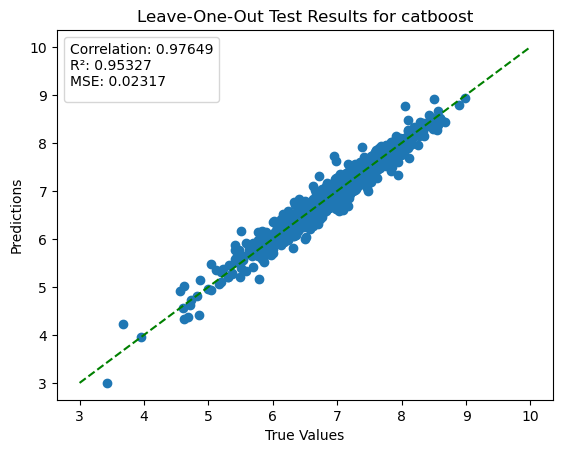

In [9]:
models = {
    "linear regression": LinearRegression(),
    "ridge": Ridge(alpha=0.01),
    "lasso": Lasso(max_iter=100000, alpha= 0.00001),
    "random forest": RandomForestRegressor(max_depth=50, n_estimators=200),
    "catboost": CatBoostRegressor(depth=8, l2_leaf_reg=5, iterations=500, verbose = 0),
}
for model in models:
    if(model == 'linear regression' or model == 'ridge' or model == 'lasso'):
        pipe = make_pipeline(preprocessor_linear, models[model])
    else:
        pipe = make_pipeline(preprocessor_trees, models[model])
    results_var = ['total.fc', 'FC_sum']
    FC_sum = df_ml['FC_sum'].values / 1000000
    total_fc = df_ml['total.fc'] 
    y = df_ml['residual']
    X = df_ml

    # Leave-One-Out Cross-Validation
    loo = LeaveOneOut()
    res_predictions = np.zeros(len(y))

    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train the model
        pipe.fit(X_train, y_train)

        # Predict on the test set
        y_pred = pipe.predict(X_test)

        res_predictions[test_index] = y_pred

    y_prediction = np.log(FC_sum) + res_predictions
    # Plotting the results
    # Calculate R-squared
    r_squared_mod = r2_score(np.log(total_fc), y_prediction)

    # Calculate correlation
    correlation_mod = np.corrcoef(np.log(total_fc), y_prediction)[0, 1]

    # Calculate mean squared error
    mse_mod = mean_squared_error(np.log(total_fc), y_prediction)
    legend_title = 'Correlation: {:.5f}\nR²: {:.5f}\nMSE: {:.5f}'.format(correlation_mod, r_squared_mod, mse_mod)
    plt.legend(title=legend_title)
    plt.scatter(np.log(total_fc), y_prediction, label='data')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(f'Leave-One-Out Test Results for {model}')
    plt.plot([3, 10], [3, 10], 'g--', label='x=y line')
    plt.show()

In [ ]:
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold
## Multiple rounds tests for model performance
results_var = ['total.fc', 'FC_sum']
models = {
    "linear regression": LinearRegression(),
    "ridge": Ridge(alpha=0.01),
    "lasso": Lasso(max_iter=100000, alpha= 0.00001),
    "random forest": RandomForestRegressor(max_depth=50, n_estimators=200),
    "catboost": CatBoostRegressor(depth=8, l2_leaf_reg=5, iterations=500, verbose = 0),
}
for model in models:
    columns = ['Model', 'r2', 'correlation', 'MSE']
    test_results = pd.DataFrame(columns=columns)
    test_results_adv = pd.DataFrame(columns=columns)
    
    k = 10
    kf = KFold(n_splits=k, shuffle=True)
        # Cross validation to train - test first layer and generate predicted residual
    for train_idx, val_idx in kf.split(X_train, y_train):
        X_train_sub, X_test_sub = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_sub, y_test_sub = y_train.iloc[train_idx], y_train.iloc[val_idx]
        linear_pipe = make_pipeline(preprocessor_trees, model)
        linear_pipe.fit(X_train_sub, y_train_sub)
        predicted_residual = linear_pipe.predict(X_test_sub)
        X_train.loc[val_idx, 'predicted_residual'] = predicted_residual
        
    X_train, X_test, y_train, y_test = train_test_split(df_ml, df_ml['residual'], test_size=0.3)
    pipe = make_pipeline(preprocessor_trees, models[model])
    total_fc = X_test['total.fc'].values
    FC_sum = X_test['FC_sum'].values / 1000000
    X_train.drop(columns=results_var, inplace=True)
    X_test.drop(columns=results_var, inplace=True)
    pipe.fit(X_train, y_train)

    # Generate x values and fitted y values
    predicted_residual = pipe.predict(X_test)

    y_values = np.log(FC_sum) + predicted_residual
    x_values = np.log(total_fc)
    # Calculate R-squared
    r_squared = r2_score(x_values, y_values)

    # Calculate correlation
    correlation = np.corrcoef(x_values, y_values)[0, 1]

    # Calculate mean squared error
    mse = mean_squared_error(x_values, y_values)
    
        # Calculate R-squared for residual
    # r_squared_r = r2_score(y_test, predicted_residual)

    # # Calculate correlation
    # correlation_r = np.corrcoef(y_test, predicted_residual)[0, 1]

    # # Calculate mean squared error
    # mse_r = mean_squared_error(y_test, predicted_residual)
    new_row = pd.DataFrame({'Model': [model],'r2':[r_squared], 'correlation':[correlation], 'MSE':[mse]})

    # Appending the new row
    test_results = pd.concat([test_results, new_row], ignore_index=True)

    mean = test_results['r2'].mean()
    std_dev = test_results['r2'].std()
    mean_mse = test_results['MSE'].mean()
    std_mse = test_results['MSE'].std()

    print(f"Model: {model}, Mean for r2: {mean:.5f}, Standard Deviation for r2: {std_dev:.5f}, Mean for MSE:{mean_mse:.5f}, Standard Deviation for MSE: {std_mse:.5f}")

    
    